# Downstream prediction 

Run this notebook on google colab to use a free GPU! 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/helicalAI/helical/blob/main/examples/notebooks/Hyena-DNA-Inference.ipynb)

In this notebook, a HyenaDNA model is used for various classifications tasks with a given sequence of nucleotides.

A HyenaDNA model (2 layers and width 256) is used to create embeddings of nucleotides.

A neural network is then trained, using the embeddings as inputs, to make a prediction.

This notebook can be used for any of the 18 [nucleotide transformer downstream tasks](https://huggingface.co/datasets/InstaDeepAI/nucleotide_transformer_downstream_tasks).

In [16]:
!pip install git+https://github.com/helicalAI/helical.git | tail -n 1

  Running command git clone --filter=blob:none --quiet https://github.com/helicalAI/helical.git /private/var/folders/pm/76n9tjdj18z7cbc55rk10yfw0000gn/T/pip-req-build-oa9zv4bw


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
from datasets import DatasetDict
import datetime
import torch
from tqdm import tqdm
from typing import Tuple

/Users/bputzeys/miniforge3/envs/head_example/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/Users/bputzeys/miniforge3/envs/head_example/lib/python3.11/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.13.0-rc1 and is not supported. 
Some things might work, some things might not.
If you were to 

### Use the Helical package to get the Hyena model
We use a small HyenaDNA model with 2 layers and width 256.

In [3]:
from helical.models.hyena_dna.model import HyenaDNA
from helical.models.hyena_dna.hyena_dna_config import HyenaDNAConfig  
device = "cuda" if torch.cuda.is_available() else "cpu"
configurer = HyenaDNAConfig(model_name="hyenadna-tiny-1k-seqlen-d256", device=device)
hyena_model = HyenaDNA(configurer=configurer)

2024-06-05, 17:01:15.550 helical.services.downloader INFO File: '/Users/bputzeys/.cache/helical/models/hyena_dna/hyenadna-tiny-1k-seqlen-d256.ckpt' exists already. File is not overwritten and nothing is downloaded.
2024-06-05, 17:01:15.551 helical.services.downloader INFO File saved to: '/Users/bputzeys/.cache/helical/models/hyena_dna/hyenadna-tiny-1k-seqlen-d256.ckpt'
2024-06-05, 17:01:15.628 helical.models.hyena_dna.pretrained_model INFO Loaded pretrained weights ok!
2024-06-05, 17:01:15.630 helical.models.hyena_dna.model INFO Model finished initializing.


### Download the dataset
Several datasets are available from the [Nucleotide Transformer](https://arxiv.org/abs/2306.15794). Using the `get_dataset_config_names()` function, we get a list of the available the datasets for the downstream tasks.

In [4]:
from datasets import get_dataset_config_names

configs = get_dataset_config_names("InstaDeepAI/nucleotide_transformer_downstream_tasks", trust_remote_code=True)
configs

['H4ac',
 'H3K36me3',
 'splice_sites_donors',
 'splice_sites_acceptors',
 'H3',
 'H4',
 'H3K4me3',
 'splice_sites_all',
 'H3K4me1',
 'H3K14ac',
 'enhancers_types',
 'promoter_no_tata',
 'H3K79me3',
 'H3K4me2',
 'promoter_tata',
 'enhancers',
 'H3K9ac',
 'promoter_all']

We can select any of the 18 downstream tasks. Let us take the `promoter_tata` as an example.

In [5]:
from datasets import load_dataset
label = "promoter_tata"
dataset = load_dataset("InstaDeepAI/nucleotide_transformer_downstream_tasks", label, trust_remote_code=True)

To familiarize ourselves with the data, we can print the first seqence and see if it is a splice site acceptor or not:

In [6]:
print("Nucleotide sequence:", dataset["train"]["sequence"][0][:10], "...")
print("Label name:", dataset["train"].config_name, "and value:", dataset["train"]["label"][0])
num_classes = len(set(dataset["train"]["label"]))
print("Number of classes:", num_classes)

Nucleotide sequence: CGCTCCCCCA ...
Label name: promoter_tata and value: 0
Number of classes: 2


Define a function that gets the embeddings for each nucleotide sequence in the training dataset.

According to the HyenaDNA [paper](https://arxiv.org/pdf/2306.15794): "[they] average across the tokens to obtain a single classification token".

In our code below, the Hyena model returns a (302, 256) matrix. We average column wise resulting in a vector of shape (256, ) for each observation.

During the training process, we also found that it is beneficial to normalize the data row-wise.

In [7]:
def get_model_inputs(dataset: DatasetDict, nbr_sequences: int = 50) -> Tuple[np.ndarray, np.ndarray]:
    """
    Parameters
    ----------
    dataset : DatasetDict
        The dataset containing the sequences and labels.
    nbr_sequences : int, optional
        The number of sequences to process at a time, by default 50.

    Returns
    -------
    Tuple[np.ndarray, np.ndarray]
        A tuple containing the input features and labels.
    """
    x_tot = np.empty((0, configurer.config['d_model'])) 
    labels_tot = np.empty((0,), dtype=int)
    
    # disable logging to avoid cluttering the output
    import logging
    logging.disable(logging.CRITICAL)

    for i in tqdm(range(0, len(dataset), nbr_sequences)):
        tokenized_sequences = hyena_model.process_data(dataset["sequence"][i:i+nbr_sequences])    
        embeddings = hyena_model.get_embeddings(tokenized_sequences[0])
        numpy_array = embeddings.cpu().detach().numpy()
        x = numpy_array.mean(axis=1)
            
        # normalize the data
        x = (x - np.mean(x, axis=0)) / np.std(x, axis=0)
        x_tot = np.concatenate((x_tot, x), axis=0)

        labels = np.array(dataset["label"][i:i+nbr_sequences])
        labels_tot = np.concatenate((labels_tot, labels), axis=0)
    return x_tot, labels_tot

It may be beneficial to do this step once and save the output in a `.npy` file.

In [8]:
x, y = get_model_inputs(dataset["train"], 50)
#np.save(f"data/train/x_{label}_norm_256", x)
#np.save(f"data/train/y_{label}_norm_256", y)

100%|██████████| 111/111 [02:14<00:00,  1.21s/it]


Load the data and one-hot-encode the labels.

We split the training set into actual training data and a test set. 

This is optional and the entire dataset can be used for training. We did this to avoid data leakage by not touching the test set during the training process.

In [9]:
#x = np.load(f"data/train/x_{label}_norm_256.npy")
#y = np.load(f"data/train/y_{label}_norm_256.npy")

# # One-hot encode the labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_encoded = to_categorical(y_encoded, num_classes=num_classes)

X_train, X_test, y_train, y_test = train_test_split(x, y_encoded, test_size=0.1, random_state=42)

### Define and train the model

In [10]:
input_shape = (configurer.config['d_model'],)

# define the model
head_model = Sequential()
head_model.add(Dense(256, activation='relu', input_shape=input_shape))
head_model.add(Dropout(0.4)) 
head_model.add(Dense(128, activation='relu'))
head_model.add(Dropout(0.4))
head_model.add(Dense(128, activation='relu'))
head_model.add(Dropout(0.4))  
head_model.add(Dense(64, activation='relu'))
head_model.add(Dropout(0.4))  
head_model.add(Dense(num_classes, activation='softmax'))

# compile the model
optimizer = Adam(learning_rate=0.001)

head_model.compile(loss='categorical_crossentropy', optimizer=optimizer)
head_model.summary()

# Setup callbacks
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
history = head_model.fit(X_train, y_train, epochs=25, batch_size=64, validation_data=(X_test, y_test), callbacks=[tensorboard_callback])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               65792     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8

In [11]:
X_unseen, y_unseen = get_model_inputs(dataset["test"], 50)
#np.save(f"data/test/x_{label}_norm_256.npy")
#np.save(f"data/test/y_{label}_norm_256.npy")

100%|██████████| 13/13 [00:15<00:00,  1.18s/it]


### Evaluate the model on the test data


In [12]:
#X_unseen = np.load(f"data/test/x_{label}_norm_256.npy")
#y_unseen = np.load(f"data/test/y_{label}_norm_256.npy")

predictions_nn = head_model.predict(X_unseen)

y_pred = np.argmax(predictions_nn, axis=1)
print("Correct predictions: {:.2f}%".format(sum(np.equal(y_pred, y_unseen))*100/len(y_unseen)))


20/20 [==============================] - 0s 548us/step
Correct predictions: 91.79%


The [Hyena](https://arxiv.org/pdf/2306.15794) and the [Nucleotide transformer](https://www.biorxiv.org/content/10.1101/2023.01.11.523679v1.full.pdf) papers, report accuracies around 95% for this task. Our results underperform in comparison. This is probably due to the much larger models being used for the NT, while the Hyena model was re-trained from scratch for this task. In future work, we want to achieve these accuracies too with either approaches.

## OPTIONAL
For reference, we also trained an SVM model and obtained similar results (to our small NN).

In [13]:
# Train the SVM model
svm_model = svm.SVC(kernel='rbf', degree=3, C=1, decision_function_shape='ovr')  # One-vs-rest strategy
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
svm_model.fit(X_train, y_train)

SVC(C=1)

In [14]:
# Evaluate the model
unseen_predictions_svm = svm_model.predict(X_unseen)

accuracy = accuracy_score(y_unseen, unseen_predictions_svm)
print("Test accuracy: {:.1f}%".format(accuracy*100))


Test accuracy: 91.9%


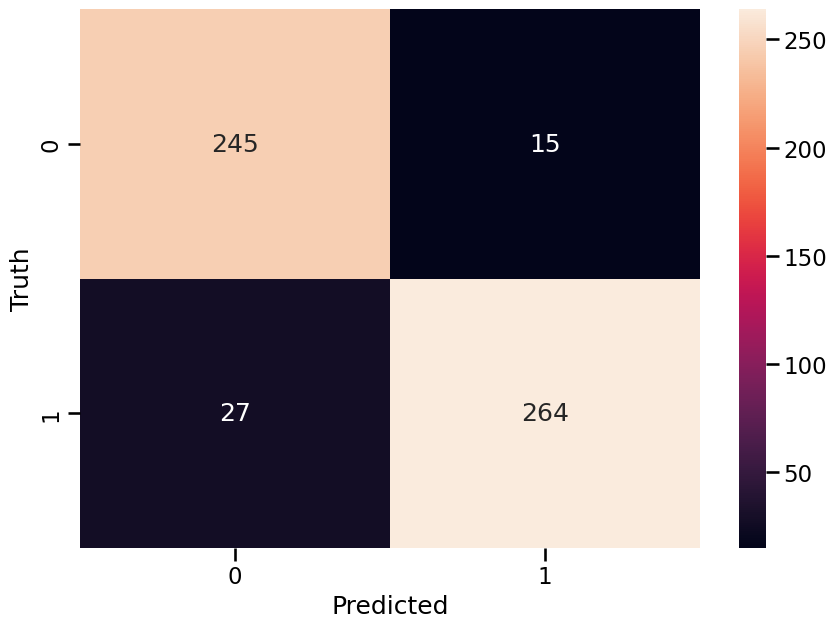

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# NN
# y_true = np.argmax(y_test, axis=1)
# y_pred_classes = np.argmax(predictions_nn, axis=1)

# SVM
y_true = y_test
y_pred_classes = svm_model.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Create a heatmap
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()